In [1]:
import json

import jsonlines
import pandas as pd

with jsonlines.open('../data/politician_tweetdata.jsonl') as reader:
    raw_politician_tweets = list(reader)

with open('../data/politicians.json') as file:
    raw_politicians = json.load(file)

[{'name': 'Bill Goodling', 'vote_match': [0, 1, 1, 4, 1, 3, 4, 3, 1, 4, 0, 3, 0, 2, 3, 1, 2, 0, 4, 3], 'ontheissues': 'https://www.ontheissues.org/PA/Bill_Goodling.htm', 'ballotpedia': None, 'party': None, 'twitters': []}, {'name': 'Floyd Spence', 'vote_match': [0, 1, 1, 4, 1, 4, 4, 4, 4, 4, 0, 1, 1, 4, 3, 3, 2, 0, 4, 1], 'ontheissues': 'https://www.ontheissues.org/House/Floyd_Spence.htm', 'ballotpedia': None, 'party': None, 'twitters': []}, {'name': 'Marsha Blackburn', 'vote_match': [0, 1, 0, 4, 0, 4, 4, 3, 3, 4, 0, 0, 3, 4, 3, 3, 0, 0, 4, 0], 'ontheissues': 'http://www.ontheissues.org/House/Marsha_Blackburn.htm', 'ballotpedia': 'https://ballotpedia.org/Marsha_Blackburn', 'party': 'Republican', 'twitters': [{'name': 'Official Twitter', 'handle': 'MarshaBlackburn'}]}, {'name': 'Olympia Snowe', 'vote_match': [4, 4, 4, 3, 3, 3, 3, 0, 3, 3, 1, 3, 3, 3, 3, 3, 0, 4, 4, 3], 'ontheissues': 'https://www.ontheissues.org/Senate/Olympia_Snowe.htm', 'ballotpedia': 'https://ballotpedia.org/Olympia_

In [11]:
from datetime import datetime

def parse_twitter_datetime(dt: str):
    return datetime.strptime(dt, '%a %b %d %H:%M:%S +0000 %Y')


tweet_df = pd.DataFrame(data={
    'tweet': [t['full_text'] for t in raw_politician_tweets],
    'author': [t['user']['screen_name'] for t in raw_politician_tweets],
    'date': [parse_twitter_datetime(t['created_at']) for t in raw_politician_tweets],
    'id': [t['id'] for t in raw_politician_tweets]
})
tweet_df

,tweet,author,date,id
0,https://t.co/OQIM0vNzg0,MarshaBlackburn,2021-04-20 00:11:23,1384298614348865547
1,.@JoeBiden :”The problem was that the refugee ...,MarshaBlackburn,2021-04-19 21:20:43,1384255663681929219
2,Sending a heartfelt congratulations to Cerelyn...,MarshaBlackburn,2021-04-19 19:41:53,1384230791157194752
3,One person one vote should be preserved. \n \n...,MarshaBlackburn,2021-04-19 17:52:10,1384203182079758340
4,Be sure to tune in!📻 @foxnewsradio https://t.c...,MarshaBlackburn,2021-04-19 17:35:55,1384199093988167688
...,...,...,...,...
12150,Decentralize.,justinamash,2021-03-19 02:48:54,1372741843146973188
12151,Duplicating state criminal laws at the federal...,justinamash,2021-03-18 17:23:11,1372599477123608580
12152,RT @WUnrepresented: Featuring luminaries and l...,justinamash,2021-03-16 19:39:04,1371908895787089921
12153,Honored and excited to engage with fantastic @...,justinamash,2021-03-16 16:38:24,1371863431528259598


In [12]:
politician_handles = [
    {
        'handle': handle['handle'],
        'handle_type': handle['name'],
        'name': p['name'],
        'party': p['party'],
        'lgbt_stance': p['vote_match'][2]
    }
    for p in raw_politicians for handle in p['twitters']
]

politician_df = pd.DataFrame.from_dict(politician_handles)
politician_df

,handle,handle_type,name,party,lgbt_stance
0,MarshaBlackburn,Official Twitter,Marsha Blackburn,Republican,0
1,pattymurray,Official Twitter,Patty Murray,Democratic,4
2,DonBeyerVA,Don Beyer Twitter feed,Sander Levin,Democratic,4
3,PeteSessions,Official Twitter,Pete Sessions,Republican,0
4,SessionsTX17,Campaign Twitter,Pete Sessions,Republican,0
...,...,...,...,...,...
198,wydenfororegon,Campaign Twitter,Ron Wyden,Democratic,4
199,joesestak,Campaign Twitter,Joe Sestak,Democratic,4
200,amashoffice,Official Twitter,Justin Amash,Libertarian,0
201,teamamash,Campaign Twitter,Justin Amash,Libertarian,0


In [13]:
politician_df['handle_type'].value_counts()

Official Twitter          80
Campaign Twitter          66
Twitter                   29
Personal Twitter          16
Don Beyer Twitter feed    11
Twitter feed               1
Name: handle_type, dtype: int64

In [14]:
politician_df = politician_df[politician_df['handle_type'] != 'Don Beyer Twitter feed']

In [24]:
tweet_df = tweet_df.merge(politician_df, left_on='author', right_on='handle')

In [21]:
import nltk
import numpy as np
from nltk import TweetTokenizer


stopwords = nltk.download('stopwords')
stop = set(nltk.corpus.stopwords.words('english'))

for punctuation in '''!@#$%^&*()?:;/.,`'”"''':
    stop.add(punctuation)


def tokenize_tweets(tweets, stopwords=None):
    tokenizer = TweetTokenizer()
    for tweet in tweets:
        tokens = tokenizer.tokenize(tweet)
        if stopwords is not None:
            tokens = [tok for tok in tokens if tok not in stopwords]
        yield tokens


def tokenize_tweets_and_flatten(tweets):
    tokenized_tweets = tokenize_tweets(tweets, stop)
    return (tok for tweet in tokenized_tweets for tok in tweet)


def calculate_word_freqs(series):
    all_tokens = np.array(list(tokenize_tweets_and_flatten(series.str.lower())))
    tokens, counts = np.unique(all_tokens, return_counts=True)
    frequencies = pd.DataFrame(
        data={'token': tokens, 'count': counts}
    )
    frequencies.set_index('token', inplace=True)
    frequencies.sort_values('count', inplace=True, ascending=False)
    return frequencies

[nltk_data] Downloading package stopwords to /home/astrid/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


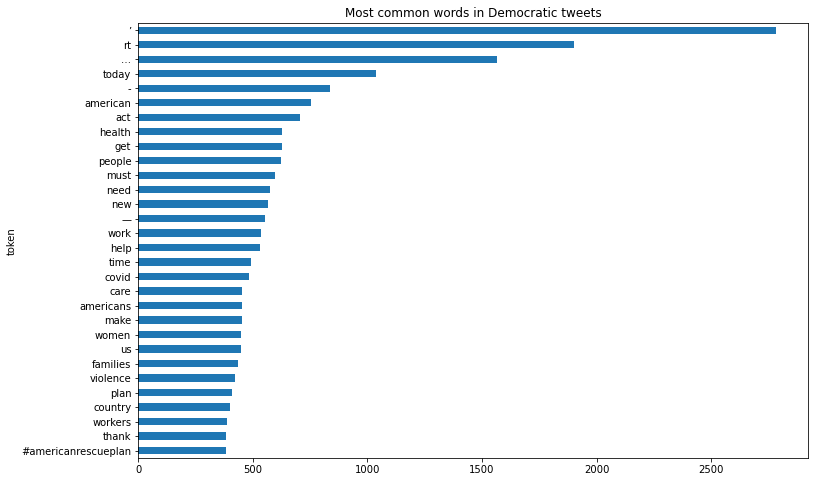

In [33]:
import matplotlib.pyplot as plt


def plot_frequencies(ax, freq_series):
    freq_series.iloc[:30].plot.barh()
    ax.invert_yaxis()
    plt.show()

FIGSIZE = (12, 8)

frequency_df = calculate_word_freqs(tweet_df[tweet_df['party'] == 'Democratic']['tweet'])
_, ax = plt.subplots(figsize=FIGSIZE)
ax.set_title('Most common words in Democratic tweets')
plot_frequencies(ax, frequency_df['count'])

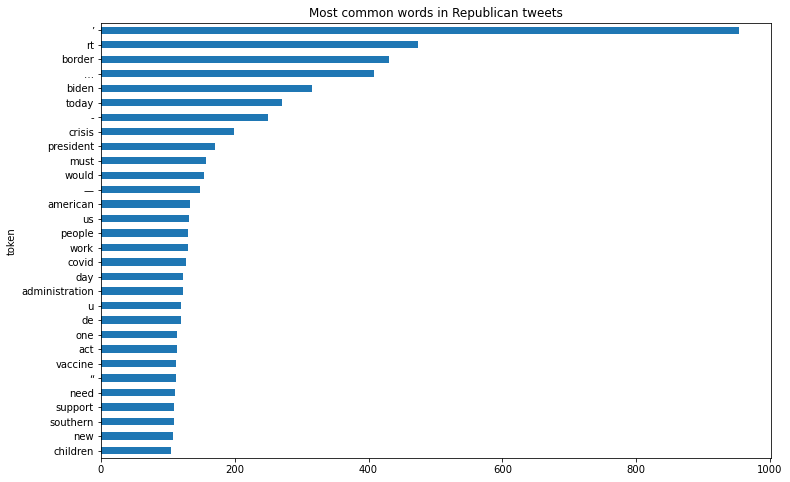

In [34]:
frequency_df = calculate_word_freqs(tweet_df[tweet_df['party'] == 'Republican']['tweet'])
_, ax = plt.subplots(figsize=FIGSIZE)
ax.set_title('Most common words in Republican tweets')
plot_frequencies(ax, frequency_df['count'])